In [1]:
# !pip -q install transformers sentencepiece rouge nltk==3.6.2

In [2]:
# !wget -q https://storage.googleapis.com/tabqgen/tabqgen_processed_csv.zip

In [3]:
# !unzip tabqgen_processed_csv.zip -d ./datasets/

In [4]:
!nvidia-smi

Sun Jun 13 16:32:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
datasets = './datasets/'

In [6]:
save_path = './'

In [7]:
from transformers import get_linear_schedule_with_warmup, AdamW, T5TokenizerFast, T5ForConditionalGeneration
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
import time, datetime
import nltk
from rouge import Rouge
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
# nltk.download('wordnet')

In [9]:
rouge_calculator = Rouge()

In [10]:
tokenizer = T5TokenizerFast.from_pretrained("t5-base")

In [11]:
model = T5ForConditionalGeneration.from_pretrained("t5-base").cuda()

In [12]:
totto_tokens = {'additional_special_tokens': ['<page_title>', '</page_title>', 
                                           '<section_title>', '</section_title>',
                                           '<table>', '</table>',
                                           '<cell>', '</cell>',
                                           '<col_header>', '</col_header>',
                                           '<highlighted_cell>','</highlighted_cell>',
                                           '<row>','</row>',
                                           '<row_header>','</row_header>',]}

In [13]:
tokenizer.add_special_tokens(totto_tokens)

16

In [14]:
model.resize_token_embeddings(len(tokenizer))

Embedding(32116, 768)

In [15]:
df = pd.read_csv(f'{datasets}/tabqgen_train.csv')

In [16]:
train, val = train_test_split(df, test_size=0.0828, random_state=42)

In [17]:
train.shape, val.shape

((110761, 4), (10000, 4))

In [18]:
train.columns, val.columns

(Index(['Unnamed: 0', 'subtable_text', 'label', 'questions'], dtype='object'),
 Index(['Unnamed: 0', 'subtable_text', 'label', 'questions'], dtype='object'))

In [19]:
train.drop(columns = ['Unnamed: 0'], inplace = True)
val.drop(columns = ['Unnamed: 0'], inplace = True)

/home/ubuntu/anaconda3/envs/torch/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
train_input_txt = train.subtable_text.values
train_target_txt = train.questions.values

val_input_txt = val.subtable_text.values
val_target_txt = val.questions.values

In [21]:
def encode_input(inp_txt):
    enc_inp_ids = []
    enc_inp_attn_mask = []

    for in_txt in tqdm_notebook(inp_txt):
        enc_input = tokenizer.encode_plus(in_txt, 
                                      add_special_tokens=True,
                                      max_length = 512,
                                      truncation = True,
                                      return_tensors = 'pt',
                                      return_attention_mask=True,
                                      return_token_type_ids=False,
                                      padding = 'max_length')
        enc_inp_ids.append(enc_input.input_ids)
        enc_inp_attn_mask.append(enc_input.attention_mask)

    enc_inp_ids = torch.cat(enc_inp_ids, dim = 0)
    enc_attn_mask = torch.cat(enc_inp_attn_mask, dim = 0)
    
    return(enc_inp_ids, enc_attn_mask)

In [22]:
def encode_target(targ_txt):
    enc_out_ids = []
    enc_out_attn_mask = []

    for trg_txt in tqdm_notebook(targ_txt):
        enc_output = tokenizer.encode_plus(trg_txt, 
                                       add_special_tokens=True,
                                       max_length=64,
                                       return_tensors='pt',
                                       return_attention_mask=True,
                                       return_token_type_ids=False,
                                       padding = 'max_length',
                                       truncation =True)

        enc_out_ids.append(enc_output.input_ids)
        enc_out_attn_mask.append(enc_output.attention_mask)

    enc_out_ids = torch.cat(enc_out_ids, dim = 0)
    enc_out_attn_mask = torch.cat(enc_out_attn_mask, dim = 0)
    
    return(enc_out_ids, enc_out_attn_mask)

In [23]:
enc_inp_ids, enc_attn_mask = encode_input(train_input_txt)
dec_inp_ids, dec_attn_mask = encode_target(train_target_txt)


train_ds = TensorDataset(enc_inp_ids, enc_attn_mask,
                  dec_inp_ids, dec_attn_mask, dec_inp_ids)


val_enc_inp_ids, val_enc_attn_mask = encode_input(val_input_txt)
val_dec_inp_ids, val_dec_attn_mask = encode_target(val_target_txt)

val_ds = TensorDataset(val_enc_inp_ids, val_enc_attn_mask,
                  val_dec_inp_ids, val_dec_attn_mask, val_dec_inp_ids)

  0%|          | 0/110761 [00:00<?, ?it/s]

  0%|          | 0/110761 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
tokenizer.decode(dec_inp_ids[1], skip_special_tokens=True)

'What was the highest temperature ever recorded in Humboldt?'

In [25]:
print('Train dataset shapes: {}, {}'.format(enc_inp_ids.shape, dec_inp_ids.shape))
print('Val dataset shapes: {}, {}'.format(val_enc_inp_ids.shape, val_dec_inp_ids.shape))

Train dataset shapes: torch.Size([110761, 512]), torch.Size([110761, 64])
Val dataset shapes: torch.Size([10000, 512]), torch.Size([10000, 64])


In [26]:
BATCH_SIZE = 8

train_dataloader = DataLoader(train_ds, batch_size = BATCH_SIZE)
val_dataloader = DataLoader(val_ds, batch_size = BATCH_SIZE)

In [27]:
EPOCHS = 5

steps = len(train_dataloader) * EPOCHS

optimizer = AdamW(model.parameters(), lr = 1e-4, eps=1e-8)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                           num_warmup_steps = 0,
                                           num_training_steps=steps)

In [28]:
def tot_bleu(ref_list_, pred_list_):
    ref_list = []
    pred_list = []
    for idx, pred in enumerate(pred_list_):
        if not len(pred.split())<=1:
          ref_list.append(ref_list_[idx])
          pred_list.append(pred_list_[idx])
    if pred_list:
      bleu = nltk.translate.bleu_score.corpus_bleu(ref_list, pred_list)
      return bleu
    else:
      return 0

In [29]:
def tot_nist(ref_list_, pred_list_):
    ref_list = []
    pred_list = []
    for idx, pred in enumerate(pred_list_):
        if not len(pred.split())<=1:
          ref_list.append(ref_list_[idx])
          pred_list.append(pred_list_[idx])
    
    if pred_list:
      nist = nltk.translate.nist_score.corpus_nist(ref_list, pred_list)
      return nist
    else:
      return 0

In [30]:
def tot_rouge(ref_list_, pred_list_):
    ref_list = []
    pred_list = []
    for idx, pred in enumerate(pred_list_):
        if not len(pred.split())<=1:
          ref_list.append(ref_list_[idx])
          pred_list.append(pred_list_[idx])
    if pred_list:
      rouge_score = rouge_calculator.get_scores(pred_list, ref_list, avg=True, ignore_empty=True)
      return rouge_score['rouge-l']['f']
    else:
      return 0

In [31]:
def tot_meteor(ref_list, pred_list):
    # print(len(pred_list))
    meteor_list = []
    for idx in range(len(ref_list)):
        if len(pred_list[idx].split())<=1:
          meteor_list.append(0)
        else:
          meteor_list.append(nltk.translate.meteor_score.meteor_score(ref_list[idx], pred_list[idx]))
    return sum(meteor_list)/len(meteor_list)

In [32]:
def compute_metrics(logits, gold):
    preds = tokenizer.batch_decode(np.argmax(logits,axis=-1), skip_special_tokens=True)
    labels = tokenizer.batch_decode(gold, skip_special_tokens=True)
    corpus_refs = [[i] for i in labels]
    
    bbleu = tot_bleu(corpus_refs, preds)
    bnist = tot_nist(corpus_refs, preds)
    brouge = tot_rouge(labels, preds)
    bmeteor = tot_meteor(corpus_refs, preds)
    
    return bbleu, bnist, brouge, bmeteor

In [33]:
def write_to_file(epoch, avg_train_loss, avg_vall_loss, avg_bleu_score, val_avg_bleu_score, avg_nist_score, val_avg_nist_score, avg_rouge_score, val_avg_rouge_score, avg_meteor_score, val_avg_meteor_score, training_time, validation_time, logits, gold):
    pred_str = tokenizer.batch_decode(np.argmax(logits,axis=-1), skip_special_tokens=True)
    label_str = tokenizer.batch_decode(gold, skip_special_tokens=True)
    with open('log.txt', 'a') as f:
        f.write(f'Epoch: {epoch + 1}; Avg Train Loss: {avg_train_loss}; Avg Val Loss: {avg_val_loss}; \
                Avg Train BLEU:{avg_bleu_score}; Avg Validation BLEU:{val_avg_bleu_score}; \
                Avg Train NIST:{avg_nist_score}; Avg Validation NIST:{val_avg_nist_score}; \
                Avg Train ROUGE:{avg_rouge_score}; Avg Validation ROUGE:{val_avg_rouge_score}; \
                Avg Train METEOR:{avg_meteor_score}; Avg Validation METEOR:{val_avg_meteor_score}; \
                Training Time: {training_time}; Validation Time: {validation_time}\n\n')
        for i in range(len(pred_str)):
            f.write(f"TARGET    >>> {label_str[i]}\n")
            f.write(f"PREDICTED >>> {pred_str[i]}\n\n")
        f.write('\n')
        f.write(120 * '~')
        f.write('\n')

In [34]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [35]:
training_stats = []
best_accuracy = 0
best_loss = 100   # dummy value

hist_loss = []
hist_bleu_scores = []
hist_nist_scores = []
hist_rouge_scores = []
hist_meteor_scores = []

val_hist_loss = []
val_hist_bleu_scores = []
val_hist_nist_scores = []
val_hist_rouge_scores = []
val_hist_meteor_scores = []

for epoch in range(EPOCHS):
    
    t0 = time.time()
    
    total_blue = 0
    total_nist = 0
    total_rouge = 0
    total_meteor = 0
    
    print(20 * "-" + " EPOCH {} / {} ".format(epoch+1, EPOCHS) + 20 * "-")
    print(10 * "=" + " TRAINING " + 10 * "=")
    
    total_train_loss = 0
    
    model.train()
    
    for nth_batch, batch in tqdm_notebook(enumerate(train_dataloader), total = len(train_dataloader)):       
        inp_ids = batch[0].to('cuda')
        inp_mask = batch[1].to('cuda')
        decoder_input_ids = batch[2].to('cuda')
        decoder_attention_mask = batch[3].to('cuda')
        gold = batch[4].to('cuda')
        
        model.zero_grad()
        
        train_output = model(input_ids = inp_ids, attention_mask = inp_mask, labels = gold)
        
        loss = train_output.loss
        logits = train_output.logits
        
        total_train_loss += loss.item()
        
        bleu, nist, rouge, meteor = compute_metrics(logits.detach().cpu().numpy(), gold.detach().cpu().numpy())
        
        total_blue+=bleu
        total_nist+=nist
        total_rouge+=rouge
        total_meteor+=meteor
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_bleu_score = total_blue / len(train_dataloader)
    avg_nist_score = total_nist / len(train_dataloader)
    avg_rouge_score = total_rouge / len(train_dataloader)
    avg_meteor_score = total_meteor / len(train_dataloader)
    
    training_time = format_time(time.time() - t0)
    
    hist_loss.append(avg_train_loss)
    hist_bleu_scores.append(avg_bleu_score)
    hist_nist_scores.append(avg_nist_score)
    hist_rouge_scores.append(avg_rouge_score)
    hist_meteor_scores.append(avg_meteor_score)
    
    print("\n>>>>> Average Train Loss : {}".format(str(avg_train_loss)))
    print("\n>>>>> Average Train BLEU Score : {}".format(str(avg_bleu_score)))
    print("\n>>>>> Average Train NIST Score : {}".format(str(avg_nist_score)))
    print("\n>>>>> Average Train ROUGE Score : {}".format(str(avg_rouge_score)))
    print("\n>>>>> Average Train METEOR Score : {}".format(str(avg_meteor_score)))
    
    

    print(10*"=" + " VALIDATION " + 10*"=")
    total_val_loss = 0

    model.eval()
    
    val_total_blue = 0
    val_total_nist = 0
    val_total_rouge = 0
    val_total_meteor = 0
    
    t0 = time.time()

    for nth_batch, batch in tqdm_notebook(enumerate(val_dataloader), total = len(val_dataloader)):
        inp_ids = batch[0].to('cuda')
        inp_mask = batch[1].to('cuda')
        decoder_input_ids = batch[2].to('cuda')
        decoder_attention_mask = batch[3].to('cuda')
        gold = batch[2].to('cuda')

        with torch.no_grad():

            val_output = model(input_ids = inp_ids, attention_mask = inp_mask,labels = gold)

            loss = val_output.loss
            logits = val_output.logits

        total_val_loss += loss.item()

        bleu, nist, rouge, meteor = compute_metrics(logits.detach().cpu().numpy(), gold.detach().cpu().numpy())
        
        val_total_blue+=bleu
        val_total_nist+=nist
        val_total_rouge+=rouge
        val_total_meteor+=meteor


    avg_val_loss = total_val_loss / len(val_dataloader)
    val_avg_bleu_score = val_total_blue / len(val_dataloader)
    val_avg_nist_score = val_total_nist / len(val_dataloader)
    val_avg_rouge_score = val_total_rouge / len(val_dataloader)
    val_avg_meteor_score = val_total_meteor / len(val_dataloader)
    
    validation_time = format_time(time.time() - t0)

    val_hist_loss.append(avg_val_loss)
    val_hist_bleu_scores.append(val_avg_bleu_score)
    val_hist_nist_scores.append(val_avg_nist_score)
    val_hist_rouge_scores.append(val_avg_rouge_score)
    val_hist_meteor_scores.append(val_avg_meteor_score)
    
    print("\n>>>>> Average Validation Loss : {}".format(str(avg_val_loss)))
    print("\n>>>>> Average Validation BLEU Score : {}".format(str(val_avg_bleu_score)))
    print("\n>>>>> Average Validation NIST Score : {}".format(str(val_avg_nist_score)))
    print("\n>>>>> Average Validation ROUGE Score : {}".format(str(val_avg_rouge_score)))
    print("\n>>>>> Average Validation METEOR Score : {}".format(str(val_avg_meteor_score)))
    
    write_to_file(epoch, avg_train_loss, avg_val_loss, avg_bleu_score, val_avg_bleu_score, avg_nist_score, val_avg_nist_score, avg_rouge_score, val_avg_rouge_score, avg_meteor_score, val_avg_meteor_score, training_time, validation_time, logits.detach().cpu().numpy(), gold.detach().cpu().numpy())    

-------------------- EPOCH 1 / 5 --------------------
========== TRAINING ==========


  0%|          | 0/13846 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.19309325300928712

>>>>> Average Train BLEU Score : 0.7124017355411619

>>>>> Average Train NIST Score : 6.4870297794137155

>>>>> Average Train ROUGE Score : 0.6630436244392623

>>>>> Average Train METEOR Score : 0.6162713180203132
========== VALIDATION ==========


  0%|          | 0/1250 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.1515485834002495

>>>>> Average Validation BLEU Score : 0.7504287037535515

>>>>> Average Validation NIST Score : 6.71668609655116

>>>>> Average Validation ROUGE Score : 0.7090437279808093

>>>>> Average Validation METEOR Score : 0.6693186455913409
-------------------- EPOCH 2 / 5 --------------------
========== TRAINING ==========


  0%|          | 0/13846 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.15061454657235449

>>>>> Average Train BLEU Score : 0.7489963740447416

>>>>> Average Train NIST Score : 6.729539986209907

>>>>> Average Train ROUGE Score : 0.7066980403173955

>>>>> Average Train METEOR Score : 0.6666047993952033
========== VALIDATION ==========


  0%|          | 0/1250 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.14579186838567257

>>>>> Average Validation BLEU Score : 0.759842472397047

>>>>> Average Validation NIST Score : 6.780385089123658

>>>>> Average Validation ROUGE Score : 0.7199414312984771

>>>>> Average Validation METEOR Score : 0.6828061030072454
-------------------- EPOCH 3 / 5 --------------------
========== TRAINING ==========


  0%|          | 0/13846 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.13278673009557623

>>>>> Average Train BLEU Score : 0.7685727092152035

>>>>> Average Train NIST Score : 6.860166272087552

>>>>> Average Train ROUGE Score : 0.7296322059666456

>>>>> Average Train METEOR Score : 0.6933440143942131
========== VALIDATION ==========


  0%|          | 0/1250 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.14593017879128456

>>>>> Average Validation BLEU Score : 0.7608979752494419

>>>>> Average Validation NIST Score : 6.7888213288458585

>>>>> Average Validation ROUGE Score : 0.7223665855978921

>>>>> Average Validation METEOR Score : 0.6840360621067989
-------------------- EPOCH 4 / 5 --------------------
========== TRAINING ==========


  0%|          | 0/13846 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.12001842073827151

>>>>> Average Train BLEU Score : 0.7834890818700305

>>>>> Average Train NIST Score : 6.957409487995344

>>>>> Average Train ROUGE Score : 0.7470823288529846

>>>>> Average Train METEOR Score : 0.7138843348326794
========== VALIDATION ==========


  0%|          | 0/1250 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.14751807779967785

>>>>> Average Validation BLEU Score : 0.7634586337571057

>>>>> Average Validation NIST Score : 6.805000174512506

>>>>> Average Validation ROUGE Score : 0.7257291650553668

>>>>> Average Validation METEOR Score : 0.6881351354353891
-------------------- EPOCH 5 / 5 --------------------
========== TRAINING ==========


  0%|          | 0/13846 [00:00<?, ?it/s]


>>>>> Average Train Loss : 0.10927611936400877

>>>>> Average Train BLEU Score : 0.7973444031366221

>>>>> Average Train NIST Score : 7.0493348654213

>>>>> Average Train ROUGE Score : 0.7633025514023539

>>>>> Average Train METEOR Score : 0.7329644937592324
========== VALIDATION ==========


  0%|          | 0/1250 [00:00<?, ?it/s]


>>>>> Average Validation Loss : 0.14947422620356082

>>>>> Average Validation BLEU Score : 0.7629887701074711

>>>>> Average Validation NIST Score : 6.79851776040136

>>>>> Average Validation ROUGE Score : 0.7252708153734733

>>>>> Average Validation METEOR Score : 0.6881473854542645


In [36]:
%%time
model.save_pretrained('table_qgen')

CPU times: user 672 ms, sys: 604 ms, total: 1.28 s
Wall time: 1.28 s


In [37]:
tokenizer.save_pretrained('table_qgen')

('table_qgen/tokenizer_config.json',
 'table_qgen/special_tokens_map.json',
 'table_qgen/spiece.model',
 'table_qgen/added_tokens.json',
 'table_qgen/tokenizer.json')

In [38]:
hist_loss

[0.19309325300928712,
 0.15061454657235449,
 0.13278673009557623,
 0.12001842073827151,
 0.10927611936400877]

In [39]:
val_hist_loss

[0.1515485834002495,
 0.14579186838567257,
 0.14593017879128456,
 0.14751807779967785,
 0.14947422620356082]

In [40]:
hist_bleu_scores

[0.7124017355411619,
 0.7489963740447416,
 0.7685727092152035,
 0.7834890818700305,
 0.7973444031366221]

In [41]:
val_hist_bleu_scores

[0.7504287037535515,
 0.759842472397047,
 0.7608979752494419,
 0.7634586337571057,
 0.7629887701074711]

In [42]:
hist_nist_scores

[6.4870297794137155,
 6.729539986209907,
 6.860166272087552,
 6.957409487995344,
 7.0493348654213]

In [43]:
val_hist_nist_scores

[6.71668609655116,
 6.780385089123658,
 6.7888213288458585,
 6.805000174512506,
 6.79851776040136]

In [44]:
hist_rouge_scores

[0.6630436244392623,
 0.7066980403173955,
 0.7296322059666456,
 0.7470823288529846,
 0.7633025514023539]

In [45]:
val_hist_rouge_scores

[0.7090437279808093,
 0.7199414312984771,
 0.7223665855978921,
 0.7257291650553668,
 0.7252708153734733]

In [46]:
hist_meteor_scores

[0.6162713180203132,
 0.6666047993952033,
 0.6933440143942131,
 0.7138843348326794,
 0.7329644937592324]

In [47]:
val_hist_meteor_scores

[0.6693186455913409,
 0.6828061030072454,
 0.6840360621067989,
 0.6881351354353891,
 0.6881473854542645]

In [48]:
def plot_graphs(train_scores, val_scores, name):
  plt.plot(train_scores)
  plt.plot(val_scores)
  plt.xlabel("Epochs")
  plt.ylabel(name)
  plt.legend(['train_'+name, 'val_'+name])
  plt.show()

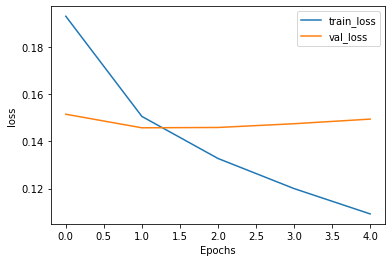

In [49]:
plot_graphs(hist_loss, val_hist_loss, 'loss')

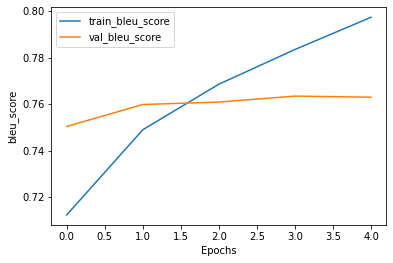

In [50]:
plot_graphs(hist_bleu_scores, val_hist_bleu_scores, 'bleu_score')

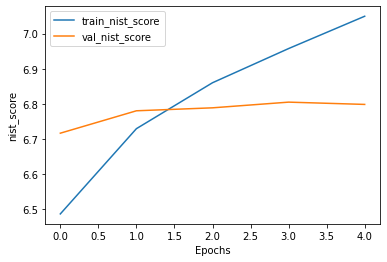

In [51]:
plot_graphs(hist_nist_scores, val_hist_nist_scores, 'nist_score')

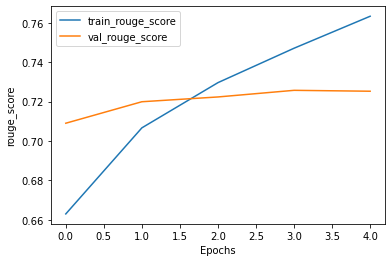

In [52]:
plot_graphs(hist_rouge_scores, val_hist_rouge_scores, 'rouge_score')

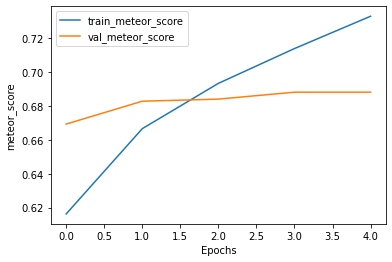

In [53]:
plot_graphs(hist_meteor_scores, val_hist_meteor_scores, 'meteor_score')